In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import gym
import time
import pygame as pgm
import sys

In [2]:
env = gym.make("CartPole-v1")
env.reset()

for step in range(100):
#   env.render()
  action = env.action_space.sample()
  observation , reward, done , info = env.step(action)
  time.sleep(0.02)

env.close()

C:\Users\harsh\AppData\Roaming\Python\Python39\site-packages\gym\envs\classic_control\cartpole.py:163: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  logger.warn(


In [3]:
observation

array([ 3.900283 ,  2.518082 , -5.1604285,  3.261644 ], dtype=float32)

In [4]:
def create_bins(num_bins_per_action=10):
    bins_cart_position = np.linspace(-4.8, 4.8, num_bins_per_action)  # bins for the cart position
    bins_cart_velocity = np.linspace(-5, 5, num_bins_per_action)  # bins for the cart velocity
    bins_pole_angle = np.linspace(-0.418, 0.418, num_bins_per_action)  # bins for the pole angle
    bins_pole_angular_velocity = np.linspace(-5, 5, num_bins_per_action)  # bins for the pole angular velocity
    bins = np.array([bins_cart_position, bins_cart_velocity, bins_pole_angle, bins_pole_angular_velocity])  # merge them
    return bins

In [5]:
NUM_BINS = 10
BINS = create_bins(NUM_BINS)

In [6]:
BINS

array([[-4.8       , -3.73333333, -2.66666667, -1.6       , -0.53333333,
         0.53333333,  1.6       ,  2.66666667,  3.73333333,  4.8       ],
       [-5.        , -3.88888889, -2.77777778, -1.66666667, -0.55555556,
         0.55555556,  1.66666667,  2.77777778,  3.88888889,  5.        ],
       [-0.418     , -0.32511111, -0.23222222, -0.13933333, -0.04644444,
         0.04644444,  0.13933333,  0.23222222,  0.32511111,  0.418     ],
       [-5.        , -3.88888889, -2.77777778, -1.66666667, -0.55555556,
         0.55555556,  1.66666667,  2.77777778,  3.88888889,  5.        ]])

In [7]:
def discretize_observation(observations, bins):
    binned_observations = []
    for i, observation in enumerate(observations):
        discretized_observation = np.digitize(observation, bins[i])
        binned_observations.append(discretized_observation)
    return tuple(binned_observations) # Important for later indexing

In [8]:
observation = env.reset()

In [9]:
mapped_observation = discretize_observation(observation, BINS)
print(mapped_observation)

(5, 5, 5, 5)


In [10]:
q_table_shape = (NUM_BINS , NUM_BINS , NUM_BINS , NUM_BINS ,env.action_space.n)

In [11]:
q_table = np.zeros(q_table_shape)

In [12]:
q_table.shape

(10, 10, 10, 10, 2)

In [13]:
def epsilon_greedy_action_selection(epsilon,q_table,discrete_state):
    
    random_number = np.random.random()
    
    
    if random_number > epsilon:
        state_row = q_table[discrete_state]
        
        action = np.argmax(state_row)
        
    else:
        action = np.random.randint(0,env.action_space.n)
        
    return action


In [14]:
def compute_next_q_value(old_q_value,reward,next_optimal_q_value):
    return old_q_value + ALPHA * (reward + GAMMA * next_optimal_q_value - old_q_value)

In [15]:
EPOCHS = 35000
ALPHA = 0.8
GAMMA = 0.9

epsilon = 1.0
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.001

epsilon = 1.0
BURN_IN = 1
EPSILON_END = 10000
EPSILON_REDUCE = 0.0001

In [16]:
def reduce_epsilon(epsilon,epoch):
    return min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*epoch)

In [17]:
def fail(done,points,reward):
    if done and points < 150:
        reward = -200
        
    return reward

<IPython.core.display.Javascript object>


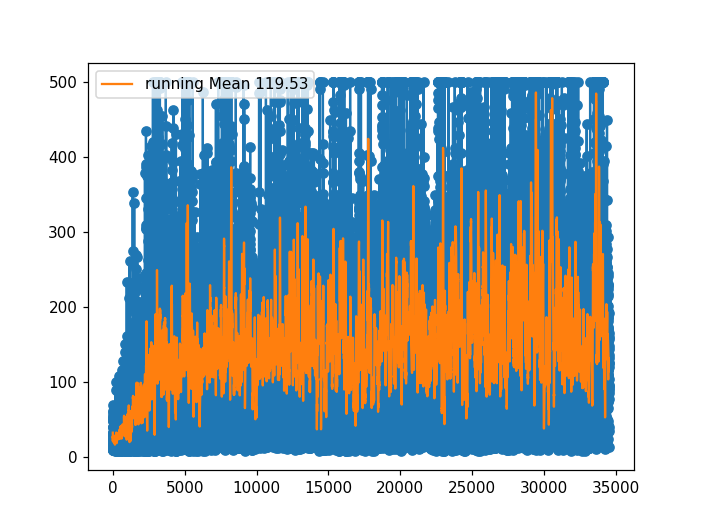

In [18]:
log_interval = 500
render_interval = 10000

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.canvas.draw()

points_log = []
mean_points_log = []
epochs = []

for epoch in range(EPOCHS):
    initial_state = env.reset()
    discretized_state = discretize_observation(initial_state,BINS)
    
    done = False
    points =0
    
    epochs.append(epoch)
    
    while not done:
        
        action = epsilon_greedy_action_selection(epsilon,q_table,discretized_state)
        next_state,reward,done,info = env.step(action)
        
        reward = fail(done,points,reward)
        
        next_state_discretized = discretize_observation(next_state,BINS)
        
        old_q_value = q_table[discretized_state + (action,)]
        
        next_optimal_q_value = np.max(q_table[next_state_discretized])
        
        next_q = compute_next_q_value(old_q_value,reward,next_optimal_q_value)
        q_table[discretized_state +(action,)] = next_q
        
        discretized_state = next_state_discretized
        points += 1
        
    epsilon = reduce_epsilon(epsilon,epoch)
    points_log.append(points)
    running_mean = round(np.mean(points_log[-30:]),2)
    mean_points_log.append(running_mean)
    
    if epoch % log_interval == 0:
        ax.clear()
        ax.scatter(epochs,points_log)
        ax.plot(epochs,points_log)
        ax.plot(epochs,mean_points_log,label = f'running Mean {running_mean}')
        plt.legend()
        fig.canvas.draw()
        
    env.close()

In [19]:
observation = env.reset()
rewards = 0

for step in range(2000):
    env.render()
    discrete_state = discretize_observation(observation,BINS)
    action = np.argmax(q_table[discrete_state])
    observation,reward,done,info = env.step(action)
    
    rewards +=1
    
    if done:
        print(f"You got {rewards} Points")
        pgm.QUIT
        break
        
env.close()


You got 260 Points
